In [1]:
import geopandas as gpd
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr
import rasterio as rio

In [ ]:
os.chdir("..")

In [ ]:
os.getcwd()

In [ ]:
csv = pd.read_csv(os.path.join(os.getcwd(), "2_intermediate/temp/csv/corrected_slopes.csv"))

In [ ]:
def compute_aic(rss, n, k):
    return n * np.log(rss / n) + 2 * k

def fixed_huber_fit(X, y, epsilon=1.345, max_iter=500):
    mdl = HuberRegressor(epsilon=epsilon, max_iter=max_iter)
    mdl.fit(X, y)
    y_pred = mdl.predict(X)
    return mdl, y_pred, (y - y_pred)

def fit_and_plot_node(df, node_id, min_obs=3):
    """Fit Huber‐AIC to one node and immediately plot the result."""
    # 1) filter
    group = df[df['node_id'] == node_id]
    if group.empty:
        raise ValueError(f"No data for node {node_id}")
    x = group['width'].values
    y = group['wse'].values
    n = len(x)
    if n < min_obs:
        raise ValueError(f"Not enough points ({n}) for node {node_id}")

    # 2) simple Huber
    mdl_s, y_s, r_s = fixed_huber_fit(x.reshape(-1,1), y)
    rss_s = np.sum(r_s**2)
    best = {
        'node_id': node_id,
        'model_type': 'simple',
        'AIC': compute_aic(rss_s, n, 2),
        'slope1': mdl_s.coef_[0],
        'intercept1': mdl_s.intercept_,
        'slope2': np.nan, 'intercept2': np.nan,
        'slope3': np.nan, 'intercept3': np.nan,
        'bp': None, 'bps': None
    }

    ux = np.unique(x)
    # 3) one‐break piecewise
    if ux.size >= 3:
        for bp in ux[1:-1]:
            left_n = np.sum(x < bp); right_n = np.sum(x >= bp)
            if (10 <= n <= 15 and (left_n < 4 or right_n < 4)) or \
               (n >= 16 and (left_n < 0.3*n or right_n < 0.3*n)):
                continue

            Xpw = np.column_stack([x, np.maximum(0, x-bp)])
            try:
                mdl_pw, y_pw, r_pw = fixed_huber_fit(Xpw, y)
            except:
                continue

            h0, h1, d = mdl_pw.intercept_, mdl_pw.coef_[0], mdl_pw.coef_[1]
            if abs(d)<0.08: continue
            sL, sR = h1, h1+d
            if (sL<=0) or (sR<=0): continue

            rss_pw = np.sum(r_pw**2)
            aic_pw = compute_aic(rss_pw, n, 3)
            if aic_pw < best['AIC']:
                best.update({
                    'model_type':'piecewise',
                    'AIC': aic_pw,
                    'slope1': sR, 'intercept1': h0 - d*bp,
                    'slope2': sL, 'intercept2': h0,
                    'slope3': np.nan, 'intercept3': np.nan,
                    'bp': bp, 'bps': None
                })

    # 4) two‐break three‐piece
    if ux.size >= 4:
        for i in range(1, ux.size-2):
            for j in range(i+1, ux.size-1):
                bp1, bp2 = ux[i], ux[j]
                seg1 = x<bp1; seg2=(x>=bp1)&(x<bp2); seg3=x>=bp2
                if min(seg1.sum(),seg2.sum(),seg3.sum())<max(4,int(0.3*n)):
                    continue

                X3 = np.column_stack([
                    x,
                    np.maximum(0,x-bp1),
                    np.maximum(0,x-bp2)
                ])
                try:
                    mdl_3, y_3, r_3 = fixed_huber_fit(X3, y)
                except:
                    continue

                h0 = mdl_3.intercept_
                h1,d1,d2 = mdl_3.coef_
                if abs(d1)<0.08 or abs(d2)<0.08: continue
                sA, sB, sC = h1, h1+d1, h1+d1+d2
                if min(sA,sB,sC)<=0: continue

                rss_3 = np.sum(r_3**2)
                aic_3 = compute_aic(rss_3,n,4)
                if aic_3 < best['AIC']:
                    best.update({
                        'model_type':'three-piece',
                        'AIC': aic_3,
                        'slope1': sC,
                        'intercept1': h0 - d1*bp1 - d2*bp2,
                        'slope2': sB,
                        'intercept2': h0 - d1*bp1,
                        'slope3': sA,
                        'intercept3': h0,
                        'bp': None,
                        'bps': (bp1,bp2)
                    })

    # 5) build summary DF
    summary = pd.DataFrame([best])

    # 6) now plot
    fig, ax = plt.subplots(figsize=(7,5))
    ax.scatter(x, y, color='k', s=20, label='data')
    xg = np.linspace(x.min(), x.max(), 400)

    m1,i1 = best['slope1'], best['intercept1']
    m2,i2 = best['slope2'], best['intercept2']
    m3,i3 = best['slope3'], best['intercept3']

    if best['model_type']=='simple':
        yg = i1 + m1*xg
        ax.plot(xg, yg, c='C0', lw=2, label=f"simple: slope={m1:.2f}")
    elif best['model_type']=='piecewise':
        bp = best['bp']
        xL,xR = xg[xg<=bp], xg[xg>bp]
        yL = i2 + m2*xL
        yR = i1 + m1*xR
        ax.plot(xL,yL,c='C2',lw=2, label=f"left: slope={m2:.2f}")
        ax.plot(xR,yR,c='C3',lw=2, label=f"right: slope={m1:.2f}")
        ax.axvline(bp, ls='--', c='gray', label=f"bp={bp:.2f}")
    else:  # three-piece
        bp1,bp2 = best['bps']
        xA = xg[xg<=bp1]
        xB = xg[(xg>bp1)&(xg<=bp2)]
        xC = xg[xg>bp2]
        yA = i3 + m3*xA
        yB = i2 + m2*xB
        yC = i1 + m1*xC
        ax.plot(xA,yA,c='C2',lw=2, label=f"seg3: slope={m3:.2f}")
        ax.plot(xB,yB,c='C0',lw=2, label=f"seg2: slope={m2:.2f}")
        ax.plot(xC,yC,c='C1',lw=2, label=f"seg1: slope={m1:.2f}")
        ax.axvline(bp1, ls='--', c='gray')
        ax.axvline(bp2, ls='--', c='gray', label=f"bps={bp1:.2f},{bp2:.2f}")

    ax.set_xlabel("width")
    ax.set_ylabel("wse")
    ax.set_title(f"Node {node_id} — {best['model_type']}")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()
    # 7) Residuals plot
    fig, ax2 = plt.subplots(figsize=(7, 4))

    # Determine which model was chosen to extract the residuals
    if best['model_type'] == 'simple':
        _, _, residuals = fixed_huber_fit(x.reshape(-1, 1), y)
    elif best['model_type'] == 'piecewise':
        bp = best['bp']
        Xpw = np.column_stack([x, np.maximum(0, x - bp)])
        _, _, residuals = fixed_huber_fit(Xpw, y)
    else:  # three-piece
        bp1, bp2 = best['bps']
        X3 = np.column_stack([
            x,
            np.maximum(0, x - bp1),
            np.maximum(0, x - bp2)
        ])
        _, _, residuals = fixed_huber_fit(X3, y)

    ax2.scatter(x, residuals, color='steelblue')
    ax2.axhline(0, color='gray', linestyle='--')
    ax2.set_xlabel("Width")
    ax2.set_ylabel("Residual (WSE - Predicted)")
    ax2.set_title(f"Residuals — Node {node_id} ({best['model_type']})")
    ax2.grid(True)
    plt.tight_layout()
    plt.show()

    return summary


In [ ]:
result = fit_and_plot_node(csv, 45242800100411, min_obs=5)
print(result)


In [ ]:
node = 49170900160201

# 1) select that group
sub = csv[csv['node_id'] == node]

# 2) scatter
plt.figure(figsize=(6,4))
plt.scatter(sub['width'], sub['wse'], alpha=0.7, edgecolor='k')
plt.xlabel("Width")
plt.ylabel("WSE")
plt.title(f"Node {node}: Width vs WSE")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
csv['node_id'].nunique()

In [ ]:
filtered_counts = (
    csv[csv['slope1'] == 'null']              # filter rows where slope1 > 1
    .groupby('node_id')['slope1']     # group by node_id
    .nunique()                        # count unique values in slope1
    .reset_index(name='unique_slope1_gt1')  # optional: reset index and rename
)

print(filtered_counts)

In [ ]:
n_nulls_per_node = (
    csv[csv['slope1'].isna()]
    .groupby('node_id')
    .size()                      # count number of rows per group
    .reset_index(name='n_null_slope1')
)

print(n_nulls_per_node)


In [ ]:
full_csv = pd.read_csv(os.path.join(os.getcwd(), "3_output/Global_22_07_25/csv/Global_slopes.csv"))

In [ ]:
full_csv['node_id'].nunique()

Linear regression

In [ ]:
# ---------------------------
# AIC + "fixed_huber_fit" (kept name for compatibility)
# ---------------------------
def compute_aic(rss, n, k):
    rss = np.maximum(rss, 1e-12)
    return n * np.log(rss / n) + 2 * k

def fixed_huber_fit(X, y):
    """
    NOTE: kept the name fixed_huber_fit for compatibility with your pipeline.
    Implementation uses OLS (LinearRegression). Returns (model, y_pred, residuals).
    """
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    residuals = y - y_pred
    return model, y_pred, residuals

# ---------------------------
# Core: OLS + AIC-driven simple / piecewise / three-piece for a list of nodes
# (same logic/thresholds as your Huber code)
# ---------------------------
def apply_ols_aic_to_node_list(raw_df, node_ids, min_obs=3, node_col='node_id'):
    """
    raw_df: DataFrame containing at least [node_col, 'width', 'wse'] (node_col may be str or int)
    node_ids: iterable of node ids (values must match raw_df[node_col])
    Returns: DataFrame (one row per node_id) with columns:
      node_id, model_type, AIC, slope1, intercept1, slope2, intercept2, slope3, intercept3, bp, bps
    """
    regression_results = []

    for node_id in node_ids:
        group = raw_df[raw_df[node_col] == node_id]
        x = group['width'].values
        y = group['wse'].values
        n = len(x)

        result = {
            node_col: node_id,
            'slope1': np.nan, 'intercept1': np.nan,
            'slope2': np.nan, 'intercept2': np.nan,
            'slope3': np.nan, 'intercept3': np.nan,
            'AIC': np.nan,
            'model_type': None,
            'bp': None,
            'bps': None
        }

        if n < min_obs:
            regression_results.append(result)
            continue

        # simple OLS fit
        try:
            model_s, y_s, res_s = fixed_huber_fit(x.reshape(-1,1), y)
        except Exception:
            regression_results.append(result)
            continue

        rss_s = np.sum(res_s**2)
        best_model = {
            'model_type': 'simple',
            'AIC': compute_aic(rss_s, n, 2),
            'slope1': model_s.coef_[0],
            'intercept1': model_s.intercept_,
            'slope2': np.nan,
            'intercept2': np.nan,
            'slope3': np.nan,
            'intercept3': np.nan,
            'bp': None,
            'bps': None
        }

        unique_x = np.unique(x)

        # three-piece (two breakpoints)
        if unique_x.size >= 4:
            for i in range(1, unique_x.size - 2):
                for j in range(i + 1, unique_x.size - 1):
                    bp1, bp2 = unique_x[i], unique_x[j]
                    seg1 = x < bp1
                    seg2 = (x >= bp1) & (x < bp2)
                    seg3 = x >= bp2
                    if min(seg1.sum(), seg2.sum(), seg3.sum()) < max(4, int(0.3 * n)):
                        continue

                    X3 = np.column_stack([
                        x,
                        np.maximum(0, x - bp1),
                        np.maximum(0, x - bp2),
                    ])
                    try:
                        model_3, y_3, res_3 = fixed_huber_fit(X3, y)
                    except Exception:
                        continue

                    h0 = model_3.intercept_
                    h1, d1, d2 = model_3.coef_
                    if abs(d1) < 0.08 or abs(d2) < 0.08:
                        continue

                    s_a = h1
                    s_b = h1 + d1
                    s_c = h1 + d1 + d2

                    i_a = h0
                    i_b = h0 - d1 * bp1
                    i_c = h0 - d1 * bp1 - d2 * bp2

                    rss_3 = np.sum(res_3**2)
                    aic_3 = compute_aic(rss_3, n, 4)
                    if aic_3 < best_model['AIC']:
                        best_model.update({
                            'model_type': 'three-piece',
                            'AIC': aic_3,
                            'slope1': s_c, 'intercept1': i_c,
                            'slope2': s_b, 'intercept2': i_b,
                            'slope3': s_a, 'intercept3': i_a,
                            'bp': None,
                            'bps': (bp1, bp2)
                        })

        # two-piece (one breakpoint)
        if unique_x.size >= 3:
            for bp in unique_x[1:-1]:
                left_n = np.sum(x < bp)
                right_n = np.sum(x >= bp)
                if (10 <= n <= 15 and (left_n < 4 or right_n < 4)) or \
                   (n >= 16 and (left_n < 0.3 * n or right_n < 0.3 * n)):
                    continue

                Xpw = np.column_stack([x, np.maximum(0, x - bp)])
                try:
                    model_pw, y_pw, res_pw = fixed_huber_fit(Xpw, y)
                except Exception:
                    continue

                h0, h1, d = model_pw.intercept_, model_pw.coef_[0], model_pw.coef_[1]
                if abs(d) < 0.08:
                    continue

                s_left = h1
                s_right = h1 + d
                i_left = h0
                i_right = h0 - d * bp

                rss_pw = np.sum(res_pw**2)
                aic_pw = compute_aic(rss_pw, n, 3)
                if aic_pw < best_model['AIC']:
                    best_model.update({
                        'model_type': 'piecewise',
                        'AIC': aic_pw,
                        'slope1': s_right, 'intercept1': i_right,
                        'slope2': s_left, 'intercept2': i_left,
                        'slope3': np.nan, 'intercept3': np.nan,
                        'bp': bp,
                        'bps': None
                    })

        result.update(best_model)
        regression_results.append(result)

    return pd.DataFrame(regression_results)

# ---------------------------
# Top-level: operate on a combined CSV (observations + regression columns per row)
# ---------------------------
def process_combined_csv_and_refill(input_csv_path,
                                    out_full_csv_path=None,
                                    out_filled_subset_csv_path=None,
                                    node_col='node_id',
                                    slope_col='slope1',
                                    min_obs=3):
    """
    Expect input CSV that contains both raw observation columns ('width','wse','node_id')
    and regression result columns (slope1, intercept1, slope2, intercept2, slope3, intercept3, model_type, AIC, bp, bps).
    This function:
      - reads the input CSV,
      - detects problematic node_ids where slope1 is NaN or slope1<0 or slope1>1,
      - re-fits only those nodes using OLS + the same AIC/piecewise logic,
      - replaces regression columns for those nodes in the full dataframe,
      - optionally writes updated full CSV and a CSV with only the filled nodes (replaced rows).
    Returns: (updated_full_df, filled_nodes_df)
    """

    # 1) read
    df = pd.read_csv(input_csv_path)
    # work on copies
    df = df.copy()

    # normalize node_id as string for stable merging
    df[node_col] = df[node_col].astype(str)

    # 2) build node-level summary from existing regression columns (one row per node)
    #    prefer first occurrence of each node to pick up existing regression columns
    reg_cols = [c for c in ['model_type','AIC','slope1','intercept1',
                            'slope2','intercept2','slope3','intercept3','bp','bps'] if c in df.columns]
    node_first = df.groupby(node_col).first().reset_index()
    reg_nodes = node_first[[node_col] + reg_cols].set_index(node_col)

    # 3) identify problematic nodes
    s = reg_nodes.get(slope_col)
    if s is None:
        raise KeyError(f"'{slope_col}' not found among regression columns in CSV.")
    s_num = pd.to_numeric(s, errors='coerce')
    problematic = reg_nodes.index[s_num.isna() | (s_num < 0) | (s_num > 1)].tolist()

    if len(problematic) == 0:
        print("No problematic node_ids found (no NaN, negative or >1 slopes).")
        # optionally save (unchanged)
        if out_full_csv_path:
            df.to_csv(out_full_csv_path, index=False)
            print(f"Saved unchanged CSV to: {out_full_csv_path}")
        return df, pd.DataFrame(columns=df.columns)

    print(f"Found {len(problematic)} problematic node_ids. Re-fitting these with OLS/AIC...")

    # 4) prepare raw observations (only width,wse,node_col)
    raw_obs = df[[node_col, 'width', 'wse']].copy()
    # drop rows missing width or wse
    raw_obs = raw_obs.dropna(subset=['width','wse'])
    # ensure node ids as string
    raw_obs[node_col] = raw_obs[node_col].astype(str)

    # 5) run OLS+AIC for only problematic nodes
    new_results = apply_ols_aic_to_node_list(raw_obs, problematic, min_obs=min_obs, node_col=node_col)
    # make index string
    new_results[node_col] = new_results[node_col].astype(str)
    new_results = new_results.set_index(node_col)

    produced_nodes = set(new_results.index).intersection(set(problematic))
    if len(produced_nodes) == 0:
        print("Warning: OLS/AIC produced no results for problematic nodes.")
        if out_full_csv_path:
            df.to_csv(out_full_csv_path, index=False)
            print(f"Saved unchanged CSV to: {out_full_csv_path}")
        return df, pd.DataFrame(columns=df.columns)

    # 6) update the node-level regression info
    for nid in produced_nodes:
        for col in reg_cols:
            if col in new_results.columns:
                reg_nodes.at[nid, col] = new_results.at[nid, col]

    reg_nodes = reg_nodes.reset_index()

    # 7) merge updated node regression info back into the full df (preserve observation rows)
    #    drop old regression columns from df (except node_col) then merge
    cols_to_drop = [c for c in reg_nodes.columns if c in df.columns and c != node_col]
    updated_full_df = df.drop(columns=cols_to_drop, errors='ignore')
    updated_full_df = updated_full_df.merge(reg_nodes, on=node_col, how='left', suffixes=('','_new'))

    # where *_new present, prefer new values
    for col in reg_cols:
        new_col = col + '_new'
        if new_col in updated_full_df.columns:
            updated_full_df[col] = updated_full_df[new_col].combine_first(updated_full_df.get(col))
            updated_full_df.drop(columns=[new_col], inplace=True)

    # 8) build filled_nodes_df: repeated rows matching original df shape but only for produced_nodes
    filled_nodes_df = updated_full_df[updated_full_df[node_col].isin(produced_nodes)].copy()

    # 9) optionally save outputs
    if out_full_csv_path:
        updated_full_df.to_csv(out_full_csv_path, index=False)
        print(f"Saved updated full CSV to: {out_full_csv_path}")
    if out_filled_subset_csv_path:
        filled_nodes_df.to_csv(out_filled_subset_csv_path, index=False)
        print(f"Saved filled-node subset CSV to: {out_filled_subset_csv_path}")

    return updated_full_df, filled_nodes_df

In [ ]:
updated_df, filled_df = process_combined_csv_and_refill(
    input_csv_path=os.path.join(os.getcwd(), "3_output/Global_22_07_25/csv/Global_slopes.csv"),
    out_full_csv_path=os.path.join(os.getcwd(), "3_output/Global_22_07_25/csv/Global_slopes_corrected.csv"),
    out_filled_subset_csv_path=os.path.join(os.getcwd(), "2_intermediate/temp/csv/corrected_slopes.csv"),
    node_col='node_id',
    slope_col='slope1',
    min_obs=10
)

print("Updated rows:", len(updated_df))
print("Filled nodes (rows):", len(filled_df))

In [ ]:
def plot_node_from_combined_df(df, node_id, node_col='node_id', outpath=None, figsize=(8,6)):
    """
    Plot scatter (width vs wse) for a specific node_id and overlay the fitted
    regression contained in the combined DataFrame.
    """
    # Ensure matching types: compare string forms
    sub = df[df[node_col].astype(str) == str(node_id)].copy()
    if sub.empty:
        raise ValueError(f"No rows for node_id {node_id}")

    row = sub.iloc[0]
    model_type = row.get('model_type', None)

    def _getf(k):
        v = row.get(k, None)
        try:
            return float(v)
        except Exception:
            return np.nan

    slope1 = _getf('slope1'); intercept1 = _getf('intercept1')
    slope2 = _getf('slope2'); intercept2 = _getf('intercept2')
    slope3 = _getf('slope3'); intercept3 = _getf('intercept3')
    bp = row.get('bp', None)
    bps = row.get('bps', None)

    x = sub['width'].values
    y = sub['wse'].values

    fig, ax = plt.subplots(figsize=figsize)
    ax.scatter(x, y, color='k', s=25, alpha=0.7, label='observed')

    xg = np.linspace(np.nanmin(x), np.nanmax(x), 500)

    # Fallback to simple OLS if regression info missing or slope1 NaN
    if (model_type is None) or (pd.isna(slope1)):
        X = x.reshape(-1,1)
        lr = LinearRegression().fit(X, y)
        m = float(lr.coef_[0]); c = float(lr.intercept_)
        yg = c + m * xg
        ax.plot(xg, yg, color='C0', lw=2, label=f"OLS fallback: slope={m:.3f}")
        ax.set_title(f"Node {node_id} — OLS fallback")
    else:
        if model_type == 'simple':
            yg = intercept1 + slope1 * xg
            ax.plot(xg, yg, color='C0', lw=2, label=f"simple: slope={slope1:.3f}")
        elif model_type == 'piecewise':
            # determine bp if missing
            if bp is None or (not np.isfinite(bp)):
                if (not pd.isna(intercept2)) and (not pd.isna(intercept1)) and (slope1 != slope2):
                    bp = (intercept2 - intercept1) / (slope1 - slope2)
                else:
                    bp = np.median(x)
            bp = float(bp)
            xL = xg[xg <= bp]; xR = xg[xg > bp]
            yL = intercept2 + slope2 * xL
            yR = intercept1 + slope1 * xR
            ax.plot(xL, yL, c='C2', lw=2, label=f"left: slope={slope2:.3f}")
            ax.plot(xR, yR, c='C3', lw=2, label=f"right: slope={slope1:.3f}")
            ax.axvline(bp, color='gray', ls='--', lw=1, label=f"bp={bp:.3f}")
            ax.set_title(f"Node {node_id} — piecewise")
        elif model_type in ('three-piece','three_piece','three piece','three_piece'):
            if (isinstance(bps, (list,tuple)) and len(bps) == 2):
                bp1, bp2 = float(bps[0]), float(bps[1])
            else:
                rng = np.max(x) - np.min(x)
                bp1 = np.min(x) + rng/3.0
                bp2 = np.min(x) + 2*rng/3.0
            xA = xg[xg <= bp1]
            xB = xg[(xg > bp1) & (xg <= bp2)]
            xC = xg[xg > bp2]
            yA = intercept3 + slope3 * xA
            yB = intercept2 + slope2 * xB
            yC = intercept1 + slope1 * xC
            ax.plot(xA, yA, c='C2', lw=2, label=f"seg-left: slope={slope3:.3f}")
            ax.plot(xB, yB, c='C0', lw=2, label=f"seg-mid: slope={slope2:.3f}")
            ax.plot(xC, yC, c='C1', lw=2, label=f"seg-right: slope={slope1:.3f}")
            ax.axvline(bp1, color='gray', ls='--', lw=1)
            ax.axvline(bp2, color='gray', ls='--', lw=1, label=f"bps={bp1:.3f},{bp2:.3f}")
            ax.set_title(f"Node {node_id} — three-piece")
        else:
            X = x.reshape(-1,1)
            lr = LinearRegression().fit(X, y)
            m = float(lr.coef_[0]); c = float(lr.intercept_)
            yg = c + m * xg
            ax.plot(xg, yg, color='C0', lw=2, label=f"OLS fallback: slope={m:.3f}")
            ax.set_title(f"Node {node_id} — unknown model_type, OLS fallback")

    ax.set_xlabel("width")
    ax.set_ylabel("wse")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()

    if outpath:
        fig.savefig(outpath, dpi=300, bbox_inches='tight')
        plt.close(fig)
        print(f"Saved plot to: {outpath}")
    else:
        plt.show()


In [ ]:
plot_node_from_combined_df(updated_df, 12795000340151)

In [ ]:
from rasterio.enums import Resampling
import requests
from tqdm import tqdm
import urllib.request
from zipfile import ZipFile
from rasterio.warp import reproject
import subprocess

In [ ]:
# === PATHS ===
dem_path = os.path.join(os.getcwd(), "0_data/External/Bathymetries/namerica/NC/pee_dee.tif")
egm2008_path = os.path.join(os.getcwd(), "0_data/External/Geoids/us_nga_egm2008_25.tif")

# Output: transformed DEM
output_dem_path = dem_path.replace(".tif", "_egm2008.tif")

# Output: offset raster
offset_path = dem_path.replace(".tif", "_navd88_minus_egm2008_offset.tif")

# === CONFIG ===
# Fixed NAVD88 → EGM2008 offset (based on location in NC/SC)
regional_offset = 0.30  # meters

# === LOAD NAVD88 DEM ===
with rio.open(dem_path) as dem_src:
    dem = dem_src.read(1)
    profile = dem_src.profile
    nodata = profile.get("nodata", None)

# === APPLY FIXED OFFSET ===
egm2008_dem = np.full_like(dem, np.nan, dtype=np.float32)

if nodata is not None:
    mask = dem != nodata
    egm2008_dem[mask] = dem[mask] - regional_offset
else:
    egm2008_dem = dem - regional_offset

# === SAVE OFFSET RASTER (for documentation/debugging) ===
offset_raster = np.full_like(dem, np.nan, dtype=np.float32)
if nodata is not None:
    offset_raster[mask] = regional_offset
else:
    offset_raster[:] = regional_offset

offset_profile = profile.copy()
offset_profile.update(dtype=rio.float32)

with rio.open(offset_path, "w", **offset_profile) as dst:
    dst.write(offset_raster.astype(np.float32), 1)

print(f"📤 Offset raster (constant) saved to:\n{offset_path}")

# === SAVE FINAL DEM (EGM2008 REFERENCED) ===
dem_egm_profile = profile.copy()
dem_egm_profile.update(dtype=rio.float32)

with rio.open(output_dem_path, "w", **dem_egm_profile) as dst:
    dst.write(egm2008_dem.astype(np.float32), 1)

print(f"✅ EGM2008-aligned DEM saved to:\n{output_dem_path}")

# === OPTIONAL: STATS ===
print("\n📊 Elevation Summary:")
print(f"  Original DEM (NAVD88) Mean: {np.nanmean(dem):.2f} m")
print(f"  EGM2008 DEM Mean         : {np.nanmean(egm2008_dem):.2f} m")
print(f"  Offset applied           : {regional_offset:.2f} m (constant)")

In [ ]:
def _warp_to_match(in_grid, dem_profile, out_tif, resampling="bilinear"):
    crs = dem_profile["crs"].to_string()
    w, h = dem_profile["width"], dem_profile["height"]
    T  = dem_profile["transform"]
    xmin, ymax = T.c, T.f
    px, py = T.a, -T.e
    xmax, ymin = xmin + px * w, ymax - py * h
    cmd = [
        "gdalwarp", "-t_srs", crs,
        "-te", str(xmin), str(ymin), str(xmax), str(ymax),
        "-ts", str(w), str(h),
        "-r", resampling, "-overwrite",
        in_grid, out_tif
    ]
    subprocess.check_call(cmd)

def to_egm2008_egm96(dem_path, egm96_grid, egm2008_grid, out_path=None):
    """
    Convert an EGM96-orthometric DEM to EGM2008:
        H_2008 = H_96 + (N_EGM96 - N_EGM2008)
    """
    if out_path is None:
        out_path = dem_path.replace(".tif", "_EGM2008.tif")

    with rio.open(dem_path) as src:
        dem = src.read(1).astype(np.float32)
        prof = src.profile.copy()
        nodata = prof.get("nodata", None)

    # Warp geoid grids onto the DEM grid
    N96_tif = "_N96_on_dem.tif"
    N08_tif = "_N08_on_dem.tif"
    _warp_to_match(egm96_grid,  prof, N96_tif)
    _warp_to_match(egm2008_grid, prof, N08_tif)

    # ΔN = N96 - N08
    with rio.open(N96_tif) as A, rio.open(N08_tif) as B:
        N96, N08 = A.read(1).astype(np.float32), B.read(1).astype(np.float32)
        validN = np.isfinite(N96) & np.isfinite(N08)
        if A.nodata is not None: validN &= (N96 != A.nodata)
        if B.nodata is not None: validN &= (N08 != B.nodata)
        dN = np.full_like(N96, np.nan, dtype=np.float32)
        dN[validN] = (N96[validN] - N08[validN])

    # Apply: H_out = H_in + ΔN
    validDEM = np.isfinite(dem)
    if nodata is not None: validDEM &= (dem != nodata)
    valid = validDEM & np.isfinite(dN)
    out = np.full_like(dem, np.nan, dtype=np.float32)
    out[valid] = dem[valid] + dN[valid]   # NOTE: plus

    prof.update(dtype=rio.float32, nodata=np.nan)
    with rio.open(out_path, "w", **prof) as dst:
        dst.write(out, 1)

    # cleanup
    for t in (N96_tif, N08_tif):
        try: os.remove(t)
        except OSError: pass

    print(f"✅ Wrote EGM2008 DEM: {out_path}")
    print(f"   Mean ΔN (N96-N08) over valid cells: {float(np.nanmean(dN)):+.3f} m")
    return out_path

In [ ]:
to_egm2008_egm96(
    dem_path=os.path.join(os.getcwd(), "0_data/External/Bathymetries/Europa/Garonne/Garonne_R.tif"),                 # your Garonne raster
    egm96_grid=os.path.join(os.getcwd(), "0_data/External/Geoids/us_nga_egm96_15.tif"),          # .gtx or .tif; path as you have it
    egm2008_grid=os.path.join(os.getcwd(), "0_data/External/Geoids/us_nga_egm2008_25.tif"),      # .gtx or .tif; path as you have it
    out_path=os.path.join(os.getcwd(), "0_data/External/Bathymetries/Europa/Garonne/garonne_EGM2008.tif")
)

In [11]:
import glob
import h5netcdf
import xarray as xr
import pandas as pd
import geopandas as gpd
import contextily as cx
import numpy as np
import matplotlib.pyplot as plt
import hvplot.xarray
import zipfile
import earthaccess

/opt/miniconda3/envs/hypsometry/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
pixcvec_results = earthaccess.search_data(short_name = 'SWOT_L2_HR_PIXCVEC_2.0', 
                                          granule_name = '*030_042_076R*') #The same cycle, pass and tile as previously downloaded

In [33]:
auth = earthaccess.login()

In [29]:
pixcvec_results

[Collection: {'Version': '2.0', 'ShortName': 'SWOT_L2_HR_PIXCVec_2.0'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -0.6460998236910882, 'SouthBoundingCoordinate': 44.13892076634671, 'EastBoundingCoordinate': 0.3829132254963383, 'NorthBoundingCoordinate': 44.915468393546846}]}, 'Track': {'Cycle': 30, 'Passes': [{'Pass': 42, 'Tiles': ['76R']}]}}}
 Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2025-03-18T18:43:07.934Z', 'BeginningDateTime': '2025-03-18T18:42:56.842Z'}}
 Size(MB): 3.057117462158203
 Data: ['https://archive.swot.podaac.earthdata.nasa.gov/podaac-swot-ops-cumulus-protected/SWOT_L2_HR_PIXCVec_2.0/SWOT_L2_HR_PIXCVec_030_042_076R_20250318T184256_20250318T184307_PIC2_01.nc']]

In [30]:
os.getcwd()

'/Users/daniel/Library/CloudStorage/GoogleDrive-ejdvc757@gmail.com/Other computers/My MacBook Pro/PhD/Dissertation'

In [19]:
os.chdir("..")

In [34]:
earthaccess.download([pixcvec_results[0]], './0_data/External/SWOT/PIXCVEC/')

QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2155.35it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:03<00:00,  3.71s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 12865.96it/s]


['0_data/External/SWOT/PIXCVEC/SWOT_L2_HR_PIXCVec_030_042_076R_20250318T184256_20250318T184307_PIC2_01.nc']

In [37]:
import glob
files = sorted(glob.glob("./0_data/External/SWOT/PIXCVEC/SWOT_L2_HR_PIXCVec_*.nc"))

if len(files) == 0:
    raise FileNotFoundError("No PIXCVec files matched the pattern.")

if len(files) == 1:
    # Single file → use open_dataset (no dask required)
    ds_PIXCVEC = xr.open_dataset(files[0], engine="h5netcdf", decode_cf=False)
else:
    # Multiple files → open individually and combine without dask
    _dsets = [xr.open_dataset(f, engine="h5netcdf", decode_cf=False) for f in files]
    try:
        ds_PIXCVEC = xr.combine_by_coords(_dsets, combine_attrs="drop_conflicts")
    finally:
        # Close sources after combining to free file handles
        for d in _dsets:
            d.close()

ds_PIXCVEC

<xarray.Dataset> Size: 367MB
Dimensions:               (points: 4706714, nchar_reach_id: 11,
                           nchar_node_id: 14, nchar_lake_id: 10,
                           nchar_obs_id: 13)
Dimensions without coordinates: points, nchar_reach_id, nchar_node_id,
                                nchar_lake_id, nchar_obs_id
Data variables:
    azimuth_index         (points) int32 19MB ...
    range_index           (points) int32 19MB ...
    latitude_vectorproc   (points) float64 38MB ...
    longitude_vectorproc  (points) float64 38MB ...
    height_vectorproc     (points) float32 19MB ...
    reach_id              (points, nchar_reach_id) |S1 52MB ...
    node_id               (points, nchar_node_id) |S1 66MB ...
    lake_id               (points, nchar_lake_id) |S1 47MB ...
    obs_id                (points, nchar_obs_id) |S1 61MB ...
    ice_clim_f            (points) int8 5MB ...
    ice_dyn_f             (points) int8 5MB ...
Attributes: (12/45)
    Conventions:                     CF-1.7
    title:                           Level 2 KaRIn high rate pixel cloud vect...
    short_name:                      L2_HR_PIXCVec
    institution:                     CNES
    source:                          Ka-band radar interferometer
    history:                         2025-03-22T05:16:08.088917Z: Creation
    ...                              ...
    xref_prior_river_db_file:        
    xref_prior_lake_db_file:         SWOT_LakeDatabase_Nom_042_20000101T00000...
    xref_reforbittrack_files:        SWOT_RefOrbitTrackTileBoundary_Nom_20000...
    xref_param_l2_hr_laketile_file:  SWOT_Param_L2_HR_LakeTile_20000101T00000...
    ellipsoid_semi_major_axis:       6378137.0
    ellipsoid_flattening:            0.0033528106647474805

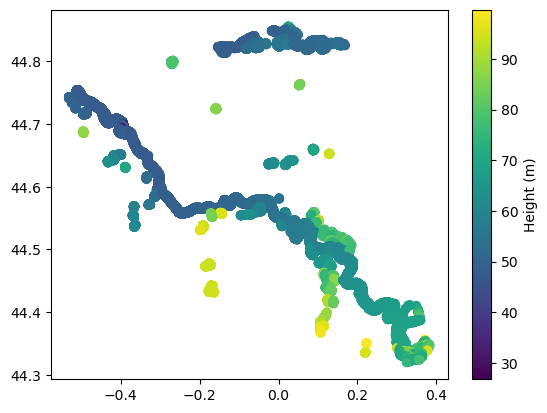

In [49]:
pixcvec_htvals = ds_PIXCVEC.height_vectorproc.compute()
pixcvec_latvals = ds_PIXCVEC.latitude_vectorproc.compute()
pixcvec_lonvals = ds_PIXCVEC.longitude_vectorproc.compute()

#Before plotting, we set all fill values to nan so that the graph shows up better spatially
pixcvec_htvals[pixcvec_htvals > 15000] = np.nan
pixcvec_latvals[pixcvec_latvals == 0] = np.nan
pixcvec_lonvals[pixcvec_lonvals == 0] = np.nan

plt.scatter(x=pixcvec_lonvals, y=pixcvec_latvals, c=pixcvec_htvals)
plt.colorbar().set_label('Height (m)')

In [51]:
# ──────────────────────────────────────────────────────────────────────────────
# 1) Open PIXCVec (no Dask). Prefer the "node" group; fallback to root if missing.
# ──────────────────────────────────────────────────────────────────────────────
def open_pixcvec_no_dask(pattern, group="node", decode_cf=False):
    files = sorted(glob.glob(pattern))
    if not files:
        raise FileNotFoundError(f"No files matched: {pattern}")

    def _try_open(path, grp):
        try:
            return xr.open_dataset(path, engine="h5netcdf", group=grp, decode_cf=decode_cf)
        except Exception:
            if grp is not None:
                return xr.open_dataset(path, engine="h5netcdf", decode_cf=decode_cf)
            raise

    if len(files) == 1:
        return _try_open(files[0], group)

    dsets = []
    try:
        for f in files:
            dsets.append(_try_open(f, group))
        ds = xr.combine_by_coords(dsets, combine_attrs="drop_conflicts")
    finally:
        for d in dsets:
            try:
                d.close()
            except Exception:
                pass
    return ds

# ──────────────────────────────────────────────────────────────────────────────
# 2) Helpers (introspection + name picking)
# ──────────────────────────────────────────────────────────────────────────────
def print_dataset_summary(ds, max_vars=200):
    print("\n=== DATASET SUMMARY ===")
    print(ds)

    print("\n=== VARIABLES (name | dims -> dtype) ===")
    for i, (name, var) in enumerate(ds.variables.items()):
        if i >= max_vars:
            print(f"... ({len(ds.variables)-max_vars} more)")
            break
        print(f"- {name:30s} | {tuple(var.dims)} -> {str(var.dtype)}")

    if getattr(ds, "attrs", None):
        print("\n=== GLOBAL ATTRIBUTES ===")
        for k, v in ds.attrs.items():
            print(f"- {k}: {v}")

def pick_first_present(ds, candidates):
    for c in candidates:
        if c in ds.variables:
            return c
    return None

def find_node_dim(ds, lat_var, lon_var):
    # Prefer the common case: lat/lon share the node dimension
    if lat_var and lon_var and ds[lat_var].dims == ds[lon_var].dims and len(ds[lat_var].dims) == 1:
        return ds[lat_var].dims[0]
    # Fallbacks
    for cand in ["node", "nodes", "n_nodes"]:
        if cand in ds.dims:
            return cand
    # Last resort: use the only 1-D dim if unambiguous
    one_d_dims = [d for d, sz in ds.sizes.items() if sz > 1]
    return one_d_dims[0] if len(one_d_dims) == 1 else None

# ──────────────────────────────────────────────────────────────────────────────
# 3) Export per-node attributes to QGIS-friendly formats
# ──────────────────────────────────────────────────────────────────────────────
def export_nodes_to_qgis(
    pattern,
    out_gpkg="nodes_pixcvec.gpkg",
    out_csv="nodes_pixcvec.csv",
    decode_cf=False,
    export_all_1d=True,         # True = export all 1-D vars along node dim
    whitelist=None              # or set to ["wse","slope","node_qflag"] to limit
):
    ds = open_pixcvec_no_dask(pattern, group="node", decode_cf=decode_cf)

    # 1) Show what’s inside
    print_dataset_summary(ds)

    # 2) Resolve critical names
    # Confirmed for your product:
    lat_var = pick_first_present(ds, ["latitude_vectorproc", "latitude", "lat", "node_latitude", "latitude_node"])
    lon_var = pick_first_present(ds, ["longitude_vectorproc", "longitude", "lon", "node_longitude", "longitude_node"])
    if lat_var is None or lon_var is None:
        raise KeyError("Could not find latitude/longitude. Tried latitude_vectorproc/longitude_vectorproc and fallbacks.")

    node_dim = find_node_dim(ds, lat_var, lon_var)
    if node_dim is None:
        raise KeyError("Could not determine the per-node dimension.")

    # Base length = length of lat/lon (truth for alignment)
    base_len = int(ds[lat_var].sizes[node_dim])
    if int(ds[lon_var].sizes[node_dim]) != base_len:
        raise ValueError(f"lat/lon length mismatch: {lat_var}={base_len}, {lon_var}={int(ds[lon_var].sizes[node_dim])}")

    # Try many possible node id names (including vectorproc variants). If none align, synthesize one.
    node_id_candidates = [
        "node_id", "nodeId", "node_index",
        "node_id_vectorproc", "node_index_vectorproc",
        "node_index_nominal", "node_id_nominal",
        "node", "nodes"
    ]
    node_id_var = None
    for cand in node_id_candidates:
        if cand in ds.variables:
            vv = ds[cand]
            if vv.dims == (node_dim,) and int(vv.sizes[node_dim]) == base_len:
                node_id_var = cand
                break

    # 3) Decide which columns to export
    cols_order = [lat_var, lon_var]  # we will insert node_id first if we find/create it

    # Helper: strictly 1-D along node dim and same length as base
    def is_strict_node_1d(name, var):
        return (var.dims == (node_dim,)) and (int(var.sizes[node_dim]) == base_len)

    skipped = []
    if export_all_1d:
        extra_1d = []
        for name, var in ds.variables.items():
            if name in (lat_var, lon_var):
                continue
            if len(var.dims) == 1:
                if is_strict_node_1d(name, var):
                    extra_1d.append(name)
                else:
                    var_len = int(var.sizes.get(node_dim, -1))
                    skipped.append((name, tuple(var.dims), var_len))
        cols_order = ([node_id_var] if node_id_var else []) + cols_order + extra_1d
    elif whitelist:
        wl = [v for v in whitelist if v in ds.variables and is_strict_node_1d(v, ds[v])]
        cols_order = ([node_id_var] if node_id_var else []) + cols_order + wl
    else:
        cols_order = ([node_id_var] if node_id_var else []) + cols_order

    # 4) Build DataFrame safely
    data = {}

    # Add node_id (existing or synthetic aligned to base_len)
    if node_id_var:
        arr = ds[node_id_var].values
        if getattr(arr, "dtype", None) is not None and arr.dtype.kind == "S":
            arr = arr.astype("U")
        data["node_id"] = arr.reshape(-1)
    else:
        data["node_id"] = np.arange(base_len, dtype=np.int64)

    # Add lat/lon
    for v in [lat_var, lon_var]:
        arr = ds[v].values
        if getattr(arr, "dtype", None) is not None and arr.dtype.kind == "S":
            arr = arr.astype("U")
        data[v] = arr.reshape(-1)

    # Add extras that match base_len
    for v in cols_order:
        if v is None or v in ("node_id", lat_var, lon_var):
            continue
        if v in ds.variables and is_strict_node_1d(v, ds[v]):
            arr = ds[v].values
            if getattr(arr, "dtype", None) is not None and arr.dtype.kind == "S":
                arr = arr.astype("U")
            data[v] = arr.reshape(-1)

    # Create DataFrame (all arrays forced to base_len)
    df = pd.DataFrame(data)
    df = df.dropna(subset=[lat_var, lon_var])

    # Ensure node_id is str (QGIS friendly IDs)
    if df["node_id"].dtype.kind in "iu":
        df["node_id"] = df["node_id"].astype(str)

    # 5) Write CSV
    df.to_csv(out_csv, index=False)
    print(f"\n✅ Wrote CSV with {len(df):,} rows and {df.shape[1]} columns → {os.path.abspath(out_csv)}")

    # 6) Write GeoPackage (EPSG:4326)
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[lon_var], df[lat_var]), crs="EPSG:4326")
    gdf.to_file(out_gpkg, driver="GPKG", layer="nodes")
    print(f"✅ Wrote GeoPackage layer 'nodes' → {os.path.abspath(out_gpkg)}")

    # Report skipped variables (different length or wrong dim)
    if export_all_1d and skipped:
        print("\nℹ️ Skipped 1-D variables not matching node length:")
        for name, dims, var_len in skipped[:20]:
            print(f"  - {name} {dims} length={var_len} (node_len={base_len})")
        if len(skipped) > 20:
            print(f"  ... and {len(skipped) - 20} more")

    return {
        "dataset": ds,
        "node_dim": node_dim,
        "node_id_var": node_id_var if node_id_var else "SYNTHETIC (0..N-1)",
        "lat_var": lat_var,
        "lon_var": lon_var,
        "exported_cols": list(df.columns),
    }

# ──────────────────────────────────────────────────────────────────────────────
# 4) RUN
# ──────────────────────────────────────────────────────────────────────────────
result = export_nodes_to_qgis(
    pattern="./0_data/External/SWOT/PIXCVEC/SWOT_L2_HR_PIXCVec_*.nc",
    out_gpkg="./0_data/External/SWOT/PIXCVEC/nodes_pixcvec.gpkg",
    out_csv ="./0_data/External/SWOT/PIXCVEC/nodes_pixcvec.csv",
    decode_cf=False,
    export_all_1d=True,              # export every 1-D node var aligned to lat/lon
    whitelist=None
)

print("\nDetected mappings:")
print(f"- node_dim: {result['node_dim']}")
print(f"- node_id : {result['node_id_var']}")
print(f"- lat     : {result['lat_var']}")
print(f"- lon     : {result['lon_var']}")
print(f"- exported columns (first 12): {result['exported_cols'][:12]}{' ...' if len(result['exported_cols'])>12 else ''}")



=== DATASET SUMMARY ===
<xarray.Dataset> Size: 367MB
Dimensions:               (points: 4706714, nchar_reach_id: 11,
                           nchar_node_id: 14, nchar_lake_id: 10,
                           nchar_obs_id: 13)
Dimensions without coordinates: points, nchar_reach_id, nchar_node_id,
                                nchar_lake_id, nchar_obs_id
Data variables:
    azimuth_index         (points) int32 19MB ...
    range_index           (points) int32 19MB ...
    latitude_vectorproc   (points) float64 38MB ...
    longitude_vectorproc  (points) float64 38MB ...
    height_vectorproc     (points) float32 19MB ...
    reach_id              (points, nchar_reach_id) |S1 52MB ...
    node_id               (points, nchar_node_id) |S1 66MB ...
    lake_id               (points, nchar_lake_id) |S1 47MB ...
    obs_id                (points, nchar_obs_id) |S1 61MB ...
    ice_clim_f            (points) int8 5MB ...
    ice_dyn_f             (points) int8 5MB ...
Attributes: (12/45)
 